<a href="https://colab.research.google.com/github/jmgang/SpoTwoFy-project-notebooks/blob/main/notebooks/4c_SpoTwoFy_Project_Create_Recommender_Engine_Pool_SentimentML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Recommender Engine Pool

*What is a recommender engine?*

A recommender engine is an information filtering system that predicts a user's preferences for a set of items (such as products, movies, or music) based on their previous interactions with those items or similar items, and provides personalized recommendations for new items.

*What is a recommender engine pool?*

The recommender engine pool is the data source from which the recommender engine gets its recommendations. It is made up of the (1) items considered for the recommendation and (2) measure/s that determines its fitness to be recommended.

| item | measure1 | measure2 |  
|------|----------|----------|
| 1    | 0.1      | 0.5      |  
| 2    | 0.2      | 0.6      |
| 3    | 0.3      | 0.7      |


In this notebook, we will create a track recommendation pool from the daily top 200 tracks data and generate track recommendations for a sample track.

In [ ]:
!pip install scikit-learn==1.3.2 -q
!pip install scikit-learn --upgrade
!pip install imbalanced-learn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import joblib # joblib==1.2.0, install if needed
import requests
from io import BytesIO
pd.options.mode.chained_assignment = None


In [ ]:
# Mount GDrive folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set home directory
import os
home_dir = "/content/drive/MyDrive/Colab Notebooks/Sprint 3/"
os.chdir(home_dir)

In [ ]:
DATA_DIRECTORY = 'https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/'
MODEL_DIRECTORY = 'https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/model_data/'

In [ ]:
def load_playlist_data(genre_names):
    playlist_df_list = []
    for genre in tqdm(genre_names):
        filename = DATA_DIRECTORY + 'playlists/' + genre.lower() + '_playlist_data.csv'
        print(filename)
        pdf = pd.read_csv(filename)
        pdf['genre'] = genre.lower()
        playlist_df_list.append(pdf)
    return pd.concat(playlist_df_list)

In [ ]:
def load_track_data(genre_names):
    track_df_list = []
    for genre in tqdm(genre_names):
        filename = DATA_DIRECTORY + 'playlists/' + genre.lower() + '_playlist_tracks_data.csv'
        tdf = pd.read_csv(filename)
        tdf = tdf[~tdf.duplicated(subset=['track_id'])]  # Remove duplicates based on 'track_id'
        tdf['genre'] = genre.lower()
        track_df_list.append(tdf)
    return pd.concat(track_df_list)

## 1. Read data

Read playlist data

In [ ]:
# chart_tracks_df = pd.read_csv('data/ph_spotify_daily_charts_tracks.csv')
# chart_tracks_df.head()

genre_names = ['opm', 'pinoy']
playlist_df = load_playlist_data(genre_names)

 50%|█████     | 1/2 [00:00<00:00,  5.16it/s]

https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/playlists/opm_playlist_data.csv
https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/playlists/pinoy_playlist_data.csv


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Read charts tracks data

In [ ]:
filename = DATA_DIRECTORY + 'charts/ph_spotify_daily_charts_tracks.csv'
charts_df = pd.read_csv(filename)
charts_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,75,0.578,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,87,0.358,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,71,0.662,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


Read tracks data

In [ ]:
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']

In [ ]:
tracks_df = load_track_data(genre_names)

100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


In [ ]:
tracks_df['genre'].value_counts()

pinoy    5027
opm      1283
Name: genre, dtype: int64

In [ ]:
tracks_df = pd.concat([tracks_df, charts_df], axis=0, ignore_index=True)

Remove tracks with no available/incomplete audio features

In [ ]:
print(len(tracks_df))
tracks_df = tracks_df.dropna(subset=feature_cols)
print(len(tracks_df))

11078
11077


In [ ]:
tracks_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre,duration_ms,num_artists,duration_mins
0,3OpGUlDmRUXh0NkIYWoIlD,Your Song,2XHTklRsNMOOQT56Zm3WS4,Parokya Ni Edgar,0kV35wyXIJKk04VRG0DdF4,168493.0,2003,70,0.636,0.159,...,0.000000,0.1120,0.658,119.766,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN
1,761frfZtZ8I2g70UsjFfBK,I Need You More Today,3XEHRbR9NMWfNzQ6TQMS9M,Caleb Santos,4TyVEjoScAou6qVjhXyYfp,233728.0,2016-12-02,63,0.474,0.522,...,0.000000,0.1230,0.448,157.225,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN
2,4r3wYgrJ3Q30ldSk05e6KP,Kiss (Never Let Me Go),0001ZVMPt41Vwzt1zsmuzp,Thyro & Yumi,0tSrGWDVpvBzlD8OWSRmg6,259714.0,2020-04-17,11,0.571,0.534,...,0.000000,0.3000,0.544,139.972,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN
3,3VcVQmMivq2ISfKUmIuvMK,Rainbow,6ZgBJRjJsK1iOJGKGZxEUv,South Border,6bMej3xtNOTiiHLdhR4wzX,347120.0,2005-01-01,63,0.660,0.224,...,0.000002,0.1010,0.382,88.011,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN
4,1FHCU1rDAeaPsBW9byjJ0Q,12:51,09DdQEMQaaq0f99vqqub3V,krissy & ericka,5M4GVkxOl3joHIkvNrAlbJ,246280.0,2011-01-01,61,0.503,0.357,...,0.000000,0.1280,0.438,136.135,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11073,4hbU7BVioG3WnoRNEy5YUf,Kitsch,6RHTUrRF63xao58xh9FXYJ,IVE,7KgFOJg5QAU9Ex9L2oTy67,195440.0,2023-03-27,80,0.800,0.792,...,0.000001,0.0495,0.455,102.000,NaN,NaN,NaN,NaN,NaN,NaN
11074,6TKDFOO6Rv6VuB9PxcXQO3,G Wolf,3PDFGpPl4ienSn5Vwisfrh,Flow G,5NyBYQ3AAjobmwtKXicPzR,197328.0,2021-08-15,66,0.744,0.572,...,0.000000,0.0949,0.535,156.071,NaN,NaN,NaN,NaN,NaN,NaN
11075,69CrOS7vEHIrhC2ILyEi0s,FLOWER,6UZ0ba50XreR4TM8u322gs,JISOO,4QuczuzDZNzCDli5Gz6DQ0,173134.0,2023-03-31,82,0.841,0.384,...,0.000002,0.0735,0.597,123.961,NaN,NaN,NaN,NaN,NaN,NaN
11076,2YXswOX5aKv6OHRKUcAMLQ,All Eyes On Me,6UZ0ba50XreR4TM8u322gs,JISOO,4QuczuzDZNzCDli5Gz6DQ0,163522.0,2023-03-31,78,0.779,0.646,...,0.000027,0.0943,0.628,110.048,NaN,NaN,NaN,NaN,NaN,NaN


Remove duplicate tracks

In [ ]:
print(len(tracks_df))
tracks_df = tracks_df.drop_duplicates(subset=['artist_id','track_name'])
print(len(tracks_df))

11077
8281


In [ ]:
tracks_df['genre'].fillna('unknown', inplace=True)

In [ ]:
tracks_df['genre'].value_counts()

pinoy      3842
unknown    3261
opm        1178
Name: genre, dtype: int64

## 2. Load model pipeline

In [ ]:
response = requests.get(MODEL_DIRECTORY + 'genre_classifier_hale_tomeklinks_extratrees_semantic.pkl')
pipeline = joblib.load(BytesIO(response.content))
pipeline

Pipeline(steps=[('scaler', MinMaxScaler()), ('sampler', TomekLinks()),
                ('model',
                 ExtraTreesClassifier(criterion='entropy', max_depth=30,
                                      min_samples_leaf=2, min_samples_split=10,
                                      n_estimators=150, random_state=42))])

In [ ]:
pipeline.named_steps['model']

ExtraTreesClassifier(criterion='entropy', max_depth=30, min_samples_leaf=2,
                     min_samples_split=10, n_estimators=150, random_state=42)

## 3. Predict Track Genres

Define features and genre id lookup dict

In [ ]:
genre_lookup = {0: 'chill_opm', 1: 'happy_opm', 2: 'hugot_opm', 3: 'sad_opm'}

Predict genre of each charting track using loaded pipeline

In [ ]:
tracks_df['predicted_genre_id'] = pipeline.predict(tracks_df[feature_cols])
tracks_df['predicted_genre'] = tracks_df['predicted_genre_id'].map(genre_lookup)
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,playlist_id,playlist_name,genre,duration_ms,num_artists,duration_mins,predicted_genre_id,predicted_genre
0,3OpGUlDmRUXh0NkIYWoIlD,Your Song,2XHTklRsNMOOQT56Zm3WS4,Parokya Ni Edgar,0kV35wyXIJKk04VRG0DdF4,168493.0,2003,70,0.636,0.159,...,0.658,119.766,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN,3,sad_opm
1,761frfZtZ8I2g70UsjFfBK,I Need You More Today,3XEHRbR9NMWfNzQ6TQMS9M,Caleb Santos,4TyVEjoScAou6qVjhXyYfp,233728.0,2016-12-02,63,0.474,0.522,...,0.448,157.225,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN,0,chill_opm
2,4r3wYgrJ3Q30ldSk05e6KP,Kiss (Never Let Me Go),0001ZVMPt41Vwzt1zsmuzp,Thyro & Yumi,0tSrGWDVpvBzlD8OWSRmg6,259714.0,2020-04-17,11,0.571,0.534,...,0.544,139.972,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN,0,chill_opm
3,3VcVQmMivq2ISfKUmIuvMK,Rainbow,6ZgBJRjJsK1iOJGKGZxEUv,South Border,6bMej3xtNOTiiHLdhR4wzX,347120.0,2005-01-01,63,0.660,0.224,...,0.382,88.011,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN,0,chill_opm
4,1FHCU1rDAeaPsBW9byjJ0Q,12:51,09DdQEMQaaq0f99vqqub3V,krissy & ericka,5M4GVkxOl3joHIkvNrAlbJ,246280.0,2011-01-01,61,0.503,0.357,...,0.438,136.135,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN,3,sad_opm


In [ ]:
tracks_df['predicted_genre'].value_counts()

chill_opm    6637
sad_opm      1224
happy_opm     402
hugot_opm      18
Name: predicted_genre, dtype: int64

## 4. Create recommender engine pool with predicted genres and probabilities

For a multiclass classification problem, `predict_proba()` returns the probability estimates for each class. For example, if you are building a model to predict the type of flower, predict_proba will output the probabilities of each flower type.

These probabilities are computed based on the input features and the model parameters learned during the training process. They are useful in making decisions based on the predicted class labels, especially when the model is uncertain about the correct class label.

We will use the probabilities from `predict_proba()` as metrics for the recommender engine pool

Show probabilities for all genres and for the predicted genre

In [ ]:
tracks_df['genre_probabilities']= pipeline.predict_proba(tracks_df[feature_cols]).tolist()
tracks_df['predicted_genre_proba'] = tracks_df['genre_probabilities'].apply(lambda x: max(x))
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,playlist_id,playlist_name,genre,duration_ms,num_artists,duration_mins,predicted_genre_id,predicted_genre,genre_probabilities,predicted_genre_proba
0,3OpGUlDmRUXh0NkIYWoIlD,Your Song,2XHTklRsNMOOQT56Zm3WS4,Parokya Ni Edgar,0kV35wyXIJKk04VRG0DdF4,168493.0,2003,70,0.636,0.159,...,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN,3,sad_opm,"[0.2562087595169088, 0.08140963764902641, 0.08...",0.581844
1,761frfZtZ8I2g70UsjFfBK,I Need You More Today,3XEHRbR9NMWfNzQ6TQMS9M,Caleb Santos,4TyVEjoScAou6qVjhXyYfp,233728.0,2016-12-02,63,0.474,0.522,...,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN,0,chill_opm,"[0.5114731811735057, 0.09824202864258884, 0.11...",0.511473
2,4r3wYgrJ3Q30ldSk05e6KP,Kiss (Never Let Me Go),0001ZVMPt41Vwzt1zsmuzp,Thyro & Yumi,0tSrGWDVpvBzlD8OWSRmg6,259714.0,2020-04-17,11,0.571,0.534,...,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN,0,chill_opm,"[0.5913187990059656, 0.0922212506876004, 0.057...",0.591319
3,3VcVQmMivq2ISfKUmIuvMK,Rainbow,6ZgBJRjJsK1iOJGKGZxEUv,South Border,6bMej3xtNOTiiHLdhR4wzX,347120.0,2005-01-01,63,0.660,0.224,...,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN,0,chill_opm,"[0.6640871715577596, 0.08727130147718377, 0.08...",0.664087
4,1FHCU1rDAeaPsBW9byjJ0Q,12:51,09DdQEMQaaq0f99vqqub3V,krissy & ericka,5M4GVkxOl3joHIkvNrAlbJ,246280.0,2011-01-01,61,0.503,0.357,...,37i9dQZF1DX4olOMiqFeqU,OPM Favorites,opm,NaN,NaN,NaN,3,sad_opm,"[0.23019506638627765, 0.01805752453853338, 0.0...",0.668071


In [ ]:
tracks_df['genre_probabilities'].values[0]

[0.2562087595169088,
 0.08140963764902641,
 0.08053756050275572,
 0.5818440423313089]

Split genre probabilities to its own columns

In [ ]:
genre_cols = [f'genre_{genre}_proba' for genre in genre_lookup.values()]
tracks_df[genre_cols] = tracks_df['genre_probabilities'].apply(pd.Series)
tracks_df = tracks_df.drop(columns=['genre_probabilities'])#drop column with probability list
tracks_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,duration_ms,num_artists,duration_mins,predicted_genre_id,predicted_genre,predicted_genre_proba,genre_chill_opm_proba,genre_happy_opm_proba,genre_hugot_opm_proba,genre_sad_opm_proba
0,3OpGUlDmRUXh0NkIYWoIlD,Your Song,2XHTklRsNMOOQT56Zm3WS4,Parokya Ni Edgar,0kV35wyXIJKk04VRG0DdF4,168493.0,2003,70,0.636,0.159,...,NaN,NaN,NaN,3,sad_opm,0.581844,0.256209,0.081410,0.080538,0.581844
1,761frfZtZ8I2g70UsjFfBK,I Need You More Today,3XEHRbR9NMWfNzQ6TQMS9M,Caleb Santos,4TyVEjoScAou6qVjhXyYfp,233728.0,2016-12-02,63,0.474,0.522,...,NaN,NaN,NaN,0,chill_opm,0.511473,0.511473,0.098242,0.112713,0.277572
2,4r3wYgrJ3Q30ldSk05e6KP,Kiss (Never Let Me Go),0001ZVMPt41Vwzt1zsmuzp,Thyro & Yumi,0tSrGWDVpvBzlD8OWSRmg6,259714.0,2020-04-17,11,0.571,0.534,...,NaN,NaN,NaN,0,chill_opm,0.591319,0.591319,0.092221,0.057893,0.258566
3,3VcVQmMivq2ISfKUmIuvMK,Rainbow,6ZgBJRjJsK1iOJGKGZxEUv,South Border,6bMej3xtNOTiiHLdhR4wzX,347120.0,2005-01-01,63,0.660,0.224,...,NaN,NaN,NaN,0,chill_opm,0.664087,0.664087,0.087271,0.081570,0.167071
4,1FHCU1rDAeaPsBW9byjJ0Q,12:51,09DdQEMQaaq0f99vqqub3V,krissy & ericka,5M4GVkxOl3joHIkvNrAlbJ,246280.0,2011-01-01,61,0.503,0.357,...,NaN,NaN,NaN,3,sad_opm,0.668071,0.230195,0.018058,0.083676,0.668071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11069,3Ua0m0YmEjrMi9XErKcNiR,Like Crazy,1oSPZhvZMIrWW5I41kPkkY,Jimin,4xc3Lc9yASZgEJGH7acWMB,212241.0,2023-03-24,90,0.629,0.733,...,NaN,NaN,NaN,0,chill_opm,0.605405,0.605405,0.167567,0.051056,0.175973
11072,0zWuvPDqBa0WM9Ffwl0rgb,Kitsch,6RHTUrRF63xao58xh9FXYJ,IVE,12p68ehzb26xvidlV2ypur,195440.0,2023-03-27,56,0.799,0.793,...,NaN,NaN,NaN,0,chill_opm,0.659864,0.659864,0.253652,0.021755,0.064729
11075,69CrOS7vEHIrhC2ILyEi0s,FLOWER,6UZ0ba50XreR4TM8u322gs,JISOO,4QuczuzDZNzCDli5Gz6DQ0,173134.0,2023-03-31,82,0.841,0.384,...,NaN,NaN,NaN,0,chill_opm,0.751673,0.751673,0.119809,0.029386,0.099131
11076,2YXswOX5aKv6OHRKUcAMLQ,All Eyes On Me,6UZ0ba50XreR4TM8u322gs,JISOO,4QuczuzDZNzCDli5Gz6DQ0,163522.0,2023-03-31,78,0.779,0.646,...,NaN,NaN,NaN,0,chill_opm,0.627955,0.627955,0.287499,0.017762,0.066784


View histogram of probabilities

<Axes: >

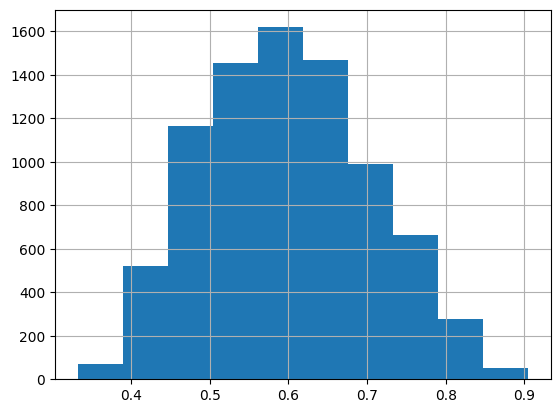

In [ ]:
tracks_df['predicted_genre_proba'].hist()

Check if model correctly predicts the genre of a track in the Top 200 charts.

- User may validate the results

    - subjectively as a listener
    - refer to another source by looking up the track in a genre-tagging site(e.g. https://www.chosic.com/music-genre-finder/)

>Q: Pick a track of choice and check if predicted genre and genre probabilities makes sense

In [ ]:
#######################
# Write code here
tracks_df[tracks_df['track_name']=='Pagkakataon'][['track_name','artist_name','predicted_genre','predicted_genre_proba']]
#
########################


,track_name,artist_name,predicted_genre,predicted_genre_proba
6284,Pagkakataon,"['Shamrock', 'Rachelle Ann Go']",chill_opm,0.674865
6302,Pagkakataon,Shamrock,chill_opm,0.681865


> Q: Pick a genre and check tracks classified with *highest* predicted genre probability. Does it make sense that the model is confident for this genre prediction?

In [ ]:
#######################
# Write code here
#
tracks_df[tracks_df['predicted_genre']=='hugot_opm'][['track_name','artist_name','predicted_genre','predicted_genre_proba']]\
            .sort_values(['predicted_genre_proba'],ascending=False)[:10]

########################


,track_name,artist_name,predicted_genre,predicted_genre_proba
1116,Say You'll Never Go,Neocolours,hugot_opm,0.503052
3454,Hard To Believe,Eraserheads,hugot_opm,0.488730
2323,Give Me A Chance,Ric Segreto,hugot_opm,0.463855
1094,Pag-ibig,APO Hiking Society,hugot_opm,0.433024
1089,I Need You Back,Raymond Lauchengco,hugot_opm,0.432637
47,Demonyo,juan karlos,hugot_opm,0.428493
448,Set You Free,Side A,hugot_opm,0.397290
5824,Set You Free,"['Side A', 'Jun Reyes']",hugot_opm,0.397290
5037,Overjoyed,Stevie Wonder,hugot_opm,0.395397
1132,Ayoko Na Sana,Ariel Rivera,hugot_opm,0.391634


> Q: Pick another genre and check tracks classified with *lowest* predicted genre probability. Does it make sense that the model is unsure for this genre prediction?

In [ ]:
#######################
# Write code here
tracks_df[tracks_df['predicted_genre']=='happy_opm'][['track_name','artist_name','predicted_genre','predicted_genre_proba']]\
            .sort_values(['predicted_genre_proba'])[:10]

#
########################


,track_name,artist_name,predicted_genre,predicted_genre_proba
9541,Naughty List (with Dixie),Liam Payne,happy_opm,0.398660
3403,Nagugustuhan,Brownman Revival,happy_opm,0.402078
9533,Copines,Aya Nakamura,happy_opm,0.402679
6500,All In My Head (Flex) (feat. Fetty Wap),Fifth Harmony,happy_opm,0.413688
10643,LOVE COUNTDOWN (Feat. Wonstein),NAYEON,happy_opm,0.418870
1396,Love Like This,"['Greg Gould', 'Inaya Day', 'Milk & Sugar']",happy_opm,0.422509
10748,Gone,TWICE,happy_opm,0.423194
3396,Walang Kasing Sarap,Brownman Revival,happy_opm,0.424687
10190,One Right Now (with The Weeknd),Post Malone,happy_opm,0.425589
4517,R.Y.F,Catriona Gray,happy_opm,0.426461


## 5. Save recommender engine pool

In [ ]:
# save data
tracks_df.to_csv("data/spotify_tracks_hale_semantic_ml_rec_pool.csv", index=False, encoding='utf-8')

In [ ]:
# NOTES
# add top 200 charts + pinoy + opm + alt rock + pop + sad opm